# Groupe E - Projet de Deep Learning 

Luis Dierick, Tom Marchal

## Mise en place

Pour réaliser ce projet, nous avons besoin de plusieurs librairies python. A savoir principalement : 
- PyTorch et Scikit Learn pour pouvoir créer notre CNN et utiliser des fonctions utiles en machine learning
- Numpy pour manipuler et calculer certaines caractéristiques sur des tableaux
- Matplotlib pour visualiser nos résultats

Pour information, le modèle a été entrainé sur un GPU Intel d'où la présence du module `intel_extension_for_pytorch` qui permet d'utiliser l'accelération GPU et optimiser les calculs sur celle-ci.

On definit également certaines variables qui resteront constantes durant l'entrainement.

In [12]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.transforms.v2 as T2
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler

import intel_extension_for_pytorch as ipex


device = 'xpu' if torch.xpu.is_available() else 'cpu' # Utilise la carte graphique, si GPU intel est disponible


NB_CLASSES = 8
CLASSES = ['battery', 'cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic', 'textile']
NB_EPOCHS = 50
BATCH_SIZE = 64
DTYPE = torch.bfloat16
LR = 0.001
L1_REG = 0.01
TRAIN_DATA = "./waste-classification-challenge/train/train/"
TEST_DATA = "./waste-classification-challenge/test/test/"


## Données
Au niveau des données, nous avons reçu initialement $\approx$ 8000 images de déchets. Le set d'entrainement contient $\approx$ 5500 images labbelées en 8 catégories (battery, cardboard, glass, metal, organic, paper, plastic, textile). Les $\approx$ 2500 images restantes ne sont pas labbelées et servent à soumettre nos predictions pour la competition Kaggle.




In [ ]:
train_transform = T2.Compose(
    [
        T2.ToImage(),
        T2.ToDtype(DTYPE),
        T2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T2.RandomHorizontalFlip(),
        #T2.RandomVerticalFlip(),
        T2.RandomRotation(degrees=30),
        #T2.RandomChannelPermutation(),
        T2.RandomResizedCrop(256, antialias=True),
        T2.ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5)),
        T2.GaussianBlur(kernel_size=9),
    ]
).to(device)

test_transform = T2.Compose(
    [
        T2.ToImage(),
        T2.ToDtype(DTYPE),
        T2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T2.Resize(256, antialias=True),
        T2.CenterCrop(256),
    ]
).to(device)

dataset = ImageFolder(root=TRAIN_DATA)
    
    

Avant tout, observons la distribution des données en termes de categories afin de voir si certaines précoutions devrons être prises avant l'entrainement d'un modèle.

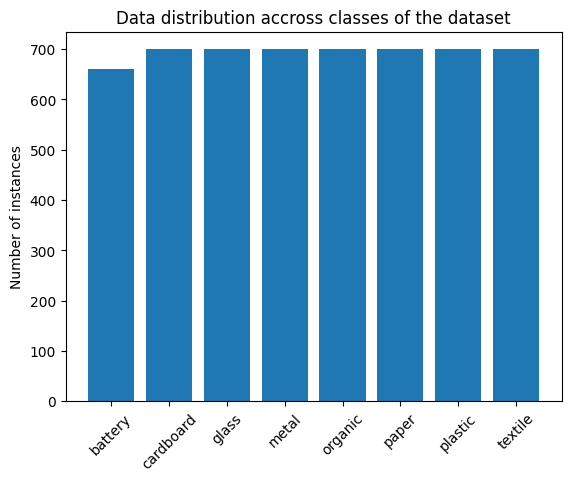

In [14]:
# Data distribution
x = np.arange(NB_CLASSES)
y = []
for i in range(NB_CLASSES):
    y.append(dataset.targets.count(i))

plt.title("Data distribution accross classes of the dataset")
plt.bar(x, y)
plt.xticks(x, CLASSES, rotation=45)
plt.ylabel("Number of instances")
plt.show()


### Préprocessing
Pour entrainer le modèle, on ne travaille pas directement sur l'image mais sur une représentation de celle sous forme d'une matrice (Tensor). Les variables `train_transform` et `test_transform` permettent de réaliser ces transformations en plus de les normaliser.

### Expension du dataset

Afin de d'améliorer au mieux la qualité de notre modèle, nous avons augmenter artificilement la taille du dataset. Grâce à la fonction transmorm de PyTorch nous pouvons facilement modifier nos images d'origines. Chaque image sera modifiée comme suit:

1. Une probabilité de 0.5 d'avoir un retournement horizontal et vertical.
2. Une rotation allant de -30 à 30 degrées
3. Une redimension aléatoire d'une taille allant de 134x134 pixels à 224x224 pixels
4. Des modifications de contraste, luminosité et de saturation
5. Et enfin, un flou Gaussien

Ces transormations sont appliquées uniquement aux images prévues à l'entrainement. Les images de validation par contre, sont utilisées sans modifications afin de se rendre compte du comportement en situation réelle du modèle.


## Campagne de selection d'un modèle

### Procédure globale

Le workflow est le suivant : on sépare les données d'entrainements en un set d'entrainement et un set de validation. Ce set de validation permet d'evaluer les performances de nos modèles afin de pouvoir trouver le plus approprié. Une fois le modèle bien définit, on le réentrainera une nouvelle fois mais sur l'intégralité des données cette fois ci.

Afin de trouver une architecture adaptée à notre objectif, nous nous sommes inspiré de modèles de classifcation d'images existant. Dans notre cas, on s'est innspiré de VGG11. En partant de sa structure de base, nous avons essayé de l'adapter au mieux afin d'obtenir les meilleures performances possibles.


### Modèle final
Notre modèle final est composé de la manière suivante : 



In [15]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        # Declare all the layers for feature extraction
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Dropout(0.3)

        )
        
        # Declare all the layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(32768, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            # nn.Linear(512, 256),
            # nn.ReLU(),
            # nn.BatchNorm1d(256),
            # nn.Dropout(0.3),
            # nn.Linear(256, 128),
            # nn.ReLU(),
            # nn.BatchNorm1d(128),
            # nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1),
            #nn.Softmax(dim=1)
        )

    def forward(self, x):
        # Apply the feature extractor in the input
        x = self.features(x)
        
        # Squeeze the three spatial dimentions in one
        x = torch.flatten(x, 1)
        
        # Classifiy the image
        x = self.classifier(x)
        return x
    

Au niveau de la loss, on utilise l'entropie
L'adaptation des poids se fera vie une descente de gradients.

Encore une fois ici, la libraire `ipex` permet d'optimiser les calculs réaliser au sein du GPU si le modèle est entrainé en 16 bits.

In [16]:
model = CustomCNN(num_classes=NB_CLASSES)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=0.01)
model = model.to(device)
criterion = criterion.to(device)
if device == 'xpu':
    model, optimizer = ipex.optimize(model, optimizer=optimizer, dtype=DTYPE)

### Entrainement
Ci-dessous se trouve la fonction d'entrainement prenant un paramètre le modèle et un set de batchs correspondant à une époque. Elle calculera pour chaque instance, une sortie au modèle et va en fonction de la valeur de loss faire de la rétroprobagation afin de recalculer les nouveaux poids du réseau de neurones.

Cette fonction va à la fin renvoyer le modèle avec les poids à jour et 2 listes contenant les valeurs d'accuracy et de loss pour l'époque venant d'avoir lieu.

In [17]:
def train_epoch(model, train_loader):
    ########## Training ##########
    model.train()

    train_n_corrects = 0
    train_n_total = 0
    train_losses = []

    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            loss = criterion(output, target)
            _, predicted = torch.max(output, 1)

            # L1_term = torch.tensor(0., requires_grad=True)
            # for name, weights in model.named_parameters():
            #     if 'bias' not in name:
            #         weights_sum = torch.sum(torch.abs(weights))
            #     L1_term = L1_term + weights_sum

            # L1_term = L1_term / nweights
            # loss = loss + L1_REG * L1_term


        train_n_corrects += (predicted == target).sum().item()
        train_n_total += target.numel()
        train_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_epoch_acc = train_n_corrects / train_n_total
    train_epoch_loss = np.mean(train_losses).__float__()

    ########## Print results ##########
    print(f"Train accuracy: {train_epoch_acc}")
    print(f"Train loss: {train_epoch_loss}")
    print("--------------------")

    return model, train_epoch_acc, train_epoch_loss

Maintenant, la fonction de validation qui prend les mêmes paramètres que la fonction `train_epoch()` sauf que celle si prendra en plus 2 listes vides. La première servira à récupérer les valeur à prédire chaque instance d'image. La seconde gardera en mémoire les la classe prédite par le modèle pour ces images.

In [18]:
def test_model(model, test_loader, val_values, val_predictions):
    ########## Testing ##########
        model.eval()
        test_n_corrects = 0
        test_n_total = 0
        test_losses = []
        
        with torch.no_grad():
            for batch_idx, (data, target) in tqdm(enumerate(test_loader), total=len(test_loader)):
                data = data.to(device)
                target = target.to(device)
                output = model(data)
                loss = criterion(output, target)
                _, predicted = torch.max(output, 1)

                val_values.append(target)
                val_predictions.append(predicted)
                test_n_corrects += (predicted == target).sum().item()
                test_n_total += target.numel()
                test_losses.append(loss.item())

        test_epoch_acc = test_n_corrects / test_n_total
        test_epoch_loss = np.mean(test_losses).__float__()

        #### Print results ####
        print(f"Test accuracy: {test_n_corrects / test_n_total}")
        print(f"Test loss: {np.mean(test_losses)}")
        print("--------------------")

        return test_epoch_acc, test_epoch_loss, val_values, val_predictions

In [ ]:
def train_model(model, full_dataset):

    if full_dataset:
        dataset.transform = train_transform
        sampler = RandomSampler(dataset)
        train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler)

    elif not full_dataset:
        train_dataset, test_dataset = random_split(dataset, [0.95, 0.05])
        train_dataset.dataset.transform = train_transform
        test_dataset.dataset.transform = test_transform
        train_sampler = RandomSampler(train_dataset)
        test_sampler = RandomSampler(test_dataset)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler)


    train_graph_acc = []
    train_graph_loss = []
    test_graph_acc = []
    test_graph_loss = []

    val_values = []
    val_predictions = []


    # nweights = 0
    # for name,weights in model.named_parameters():
    #     if 'bias' not in name:
    #         nweights = nweights + weights.numel()
        

    for epoch in range(NB_EPOCHS):
        print(f"Epoch {epoch}")
        model, train_epoch_acc, train_epoch_loss = train_epoch(model, train_loader)

        if not full_dataset:
            val_values = []
            val_predictions = []

            test_epoch_acc, test_epoch_loss, val_values, val_predictions = test_model(model, test_loader, val_values, val_predictions)
            
            train_graph_acc.append(train_epoch_acc)
            train_graph_loss.append(train_epoch_loss)
            test_graph_acc.append(test_epoch_acc)
            test_graph_loss.append(test_epoch_loss)
    
    
    if not full_dataset:
        ########## Visualise results ##########
        x = np.arange(1, NB_EPOCHS + 1)
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('Number of epochs')
        ax1.set_ylabel('Accuracy')
        ax1.plot(x, train_graph_acc, label='Train Accuracy', color='tab:blue')
        ax1.plot(x, test_graph_acc, label='Test Accuracy', color='tab:cyan')
        ax1.tick_params(axis='y')
        ax2 = ax1.twinx()
        ax2.set_ylabel('Loss')
        ax2.plot(x, train_graph_loss, label='Train Loss', color='tab:green')
        ax2.plot(x, test_graph_loss, label='Test Loss', color='tab:olive')
        ax2.tick_params(axis='y')
        fig.legend()
        plt.show()

        plt.figure()
        cm = confusion_matrix(torch.cat(val_values).cpu(), torch.cat(val_predictions).cpu())
        cm_display = ConfusionMatrixDisplay(cm, display_labels=CLASSES)
        cm_display.plot(xticks_rotation='vertical')
        plt.show()
    
    return model

### Techniques de régularisation

- Régularisation L1 / L2 (weight decay)
- Dropout

### Résultats

Epoch 0


100%|██████████| 70/70 [00:20<00:00,  3.35it/s]


Train accuracy: 0.45593525179856115
Train loss: 1.8376836333956037
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.57it/s]


Test accuracy: 0.5863309352517986
Test loss: 1.7309027777777777
--------------------
Epoch 1


100%|██████████| 70/70 [00:20<00:00,  3.38it/s]


Train accuracy: 0.6366906474820144
Train loss: 1.670885407924652
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.45it/s]


Test accuracy: 0.6339928057553957
Test loss: 1.6662326388888888
--------------------
Epoch 2


100%|██████████| 70/70 [00:20<00:00,  3.36it/s]


Train accuracy: 0.7039118705035972
Train loss: 1.6009360671043396
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.49it/s]


Test accuracy: 0.6357913669064749
Test loss: 1.6566840277777777
--------------------
Epoch 3


100%|██████████| 70/70 [00:20<00:00,  3.39it/s]


Train accuracy: 0.741681654676259
Train loss: 1.5614585297448293
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.56it/s]


Test accuracy: 0.6717625899280576
Test loss: 1.6263020833333333
--------------------
Epoch 4


100%|██████████| 70/70 [00:20<00:00,  3.41it/s]


Train accuracy: 0.7866456834532374
Train loss: 1.5202946032796587
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.51it/s]


Test accuracy: 0.7005395683453237
Test loss: 1.5989583333333333
--------------------
Epoch 5


100%|██████████| 70/70 [00:20<00:00,  3.42it/s]


Train accuracy: 0.8138489208633094
Train loss: 1.497147798538208
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.56it/s]


Test accuracy: 0.7482014388489209
Test loss: 1.5442708333333333
--------------------
Epoch 6


100%|██████████| 70/70 [00:20<00:00,  3.41it/s]


Train accuracy: 0.841501798561151
Train loss: 1.4660450799124582
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.63it/s]


Test accuracy: 0.7715827338129496
Test loss: 1.5238715277777777
--------------------
Epoch 7


100%|██████████| 70/70 [00:20<00:00,  3.38it/s]


Train accuracy: 0.8767985611510791
Train loss: 1.4311827659606933
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.50it/s]


Test accuracy: 0.762589928057554
Test loss: 1.5460069444444444
--------------------
Epoch 8


100%|██████████| 70/70 [00:21<00:00,  3.31it/s]


Train accuracy: 0.8934352517985612
Train loss: 1.407857860837664
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.60it/s]


Test accuracy: 0.7356115107913669
Test loss: 1.5611979166666667
--------------------
Epoch 9


100%|██████████| 70/70 [00:20<00:00,  3.46it/s]


Train accuracy: 0.9089478417266187
Train loss: 1.3966450197356088
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.69it/s]


Test accuracy: 0.8030575539568345
Test loss: 1.4965277777777777
--------------------
Epoch 10


100%|██████████| 70/70 [00:20<00:00,  3.39it/s]


Train accuracy: 0.9282823741007195
Train loss: 1.375306590965816
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.51it/s]


Test accuracy: 0.8048561151079137
Test loss: 1.4856770833333333
--------------------
Epoch 11


100%|██████████| 70/70 [00:20<00:00,  3.47it/s]


Train accuracy: 0.9386241007194245
Train loss: 1.3616231526647296
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.77it/s]


Test accuracy: 0.7985611510791367
Test loss: 1.4943576388888888
--------------------
Epoch 12


100%|██████████| 70/70 [00:19<00:00,  3.55it/s]


Train accuracy: 0.9496402877697842
Train loss: 1.3490798115730285
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.84it/s]


Test accuracy: 0.8219424460431655
Test loss: 1.4782986111111112
--------------------
Epoch 13


100%|██████████| 70/70 [00:19<00:00,  3.59it/s]


Train accuracy: 0.9575089928057554
Train loss: 1.336398526600429
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.88it/s]


Test accuracy: 0.7985611510791367
Test loss: 1.5
--------------------
Epoch 14


100%|██████████| 70/70 [00:19<00:00,  3.62it/s]


Train accuracy: 0.9649280575539568
Train loss: 1.3285788076264518
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.01it/s]


Test accuracy: 0.8201438848920863
Test loss: 1.4813368055555556
--------------------
Epoch 15


100%|██████████| 70/70 [00:20<00:00,  3.42it/s]


Train accuracy: 0.9732464028776978
Train loss: 1.3165999838284084
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.60it/s]


Test accuracy: 0.8210431654676259
Test loss: 1.4622395833333333
--------------------
Epoch 16


100%|██████████| 70/70 [00:20<00:00,  3.42it/s]


Train accuracy: 0.9763938848920863
Train loss: 1.3113967861448015
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.66it/s]


Test accuracy: 0.8399280575539568
Test loss: 1.4574652777777777
--------------------
Epoch 17


100%|██████████| 70/70 [00:19<00:00,  3.52it/s]


Train accuracy: 0.97931654676259
Train loss: 1.308159337724958
--------------------


100%|██████████| 18/18 [00:02<00:00,  7.84it/s]


Test accuracy: 0.8300359712230215
Test loss: 1.4683159722222223
--------------------
Epoch 18


100%|██████████| 70/70 [00:19<00:00,  3.52it/s]


Train accuracy: 0.9829136690647482
Train loss: 1.3037148203168596
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.53it/s]


Test accuracy: 0.829136690647482
Test loss: 1.4583333333333333
--------------------
Epoch 19


100%|██████████| 70/70 [00:19<00:00,  3.60it/s]


Train accuracy: 0.9838129496402878
Train loss: 1.3020576647349766
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.81it/s]


Test accuracy: 0.835431654676259
Test loss: 1.4609375
--------------------
Epoch 20


100%|██████████| 70/70 [00:19<00:00,  3.60it/s]


Train accuracy: 0.9883093525179856
Train loss: 1.2975379603249686
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.68it/s]


Test accuracy: 0.8381294964028777
Test loss: 1.4509548611111112
--------------------
Epoch 21


100%|██████████| 70/70 [00:19<00:00,  3.59it/s]


Train accuracy: 0.9910071942446043
Train loss: 1.2935611861092704
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.74it/s]


Test accuracy: 0.8444244604316546
Test loss: 1.4513888888888888
--------------------
Epoch 22


100%|██████████| 70/70 [00:19<00:00,  3.60it/s]


Train accuracy: 0.9921312949640287
Train loss: 1.2904166834695
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.60it/s]


Test accuracy: 0.8561151079136691
Test loss: 1.4457465277777777
--------------------
Epoch 23


100%|██████████| 70/70 [00:20<00:00,  3.36it/s]


Train accuracy: 0.9925809352517986
Train loss: 1.289875452859061
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.56it/s]


Test accuracy: 0.8561151079136691
Test loss: 1.4379340277777777
--------------------
Epoch 24


100%|██████████| 70/70 [00:20<00:00,  3.48it/s]


Train accuracy: 0.9937050359712231
Train loss: 1.2860720719609942
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.62it/s]


Test accuracy: 0.8471223021582733
Test loss: 1.4466145833333333
--------------------
Epoch 25


100%|██████████| 70/70 [00:19<00:00,  3.61it/s]


Train accuracy: 0.9946043165467626
Train loss: 1.2849213208471026
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.92it/s]


Test accuracy: 0.8561151079136691
Test loss: 1.4401041666666667
--------------------
Epoch 26


100%|██████████| 70/70 [00:19<00:00,  3.59it/s]


Train accuracy: 0.9948291366906474
Train loss: 1.2856665526117597
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.43it/s]


Test accuracy: 0.8390287769784173
Test loss: 1.4448784722222223
--------------------
Epoch 27


100%|██████████| 70/70 [00:18<00:00,  3.69it/s]


Train accuracy: 0.9952787769784173
Train loss: 1.2853900211197988
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.65it/s]


Test accuracy: 0.8435251798561151
Test loss: 1.4440104166666667
--------------------
Epoch 28


100%|██████████| 70/70 [00:19<00:00,  3.59it/s]


Train accuracy: 0.9957284172661871
Train loss: 1.282853024346488
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.61it/s]


Test accuracy: 0.8606115107913669
Test loss: 1.4340277777777777
--------------------
Epoch 29


100%|██████████| 70/70 [00:18<00:00,  3.72it/s]


Train accuracy: 0.9961780575539568
Train loss: 1.2821760960987636
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.89it/s]


Test accuracy: 0.8444244604316546
Test loss: 1.4409722222222223
--------------------
Epoch 30


100%|██████████| 70/70 [00:18<00:00,  3.77it/s]


Train accuracy: 0.9964028776978417
Train loss: 1.2815203768866403
--------------------


100%|██████████| 18/18 [00:01<00:00,  9.06it/s]


Test accuracy: 0.862410071942446
Test loss: 1.4344618055555556
--------------------
Epoch 31


100%|██████████| 70/70 [00:18<00:00,  3.77it/s]


Train accuracy: 0.9964028776978417
Train loss: 1.2814362951687404
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.91it/s]


Test accuracy: 0.862410071942446
Test loss: 1.4375
--------------------
Epoch 32


100%|██████████| 70/70 [00:18<00:00,  3.77it/s]


Train accuracy: 0.9968525179856115
Train loss: 1.2811970727784292
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.96it/s]


Test accuracy: 0.8471223021582733
Test loss: 1.4470486111111112
--------------------
Epoch 33


100%|██████████| 70/70 [00:18<00:00,  3.77it/s]


Train accuracy: 0.9968525179856115
Train loss: 1.2808288420949663
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.62it/s]


Test accuracy: 0.8588129496402878
Test loss: 1.4375
--------------------
Epoch 34


100%|██████████| 70/70 [00:20<00:00,  3.37it/s]


Train accuracy: 0.9970773381294964
Train loss: 1.2804622411727906
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.06it/s]


Test accuracy: 0.8570143884892086
Test loss: 1.4357638888888888
--------------------
Epoch 35


100%|██████████| 70/70 [00:22<00:00,  3.06it/s]


Train accuracy: 0.9970773381294964
Train loss: 1.2804576992988586
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.06it/s]


Test accuracy: 0.8687050359712231
Test loss: 1.4318576388888888
--------------------
Epoch 36


100%|██████████| 70/70 [00:22<00:00,  3.16it/s]


Train accuracy: 0.9970773381294964
Train loss: 1.2807828562600272
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.31it/s]


Test accuracy: 0.8642086330935251
Test loss: 1.4348958333333333
--------------------
Epoch 37


100%|██████████| 70/70 [00:22<00:00,  3.17it/s]


Train accuracy: 0.9975269784172662
Train loss: 1.2803406476974488
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.39it/s]


Test accuracy: 0.8552158273381295
Test loss: 1.4353298611111112
--------------------
Epoch 38


100%|██████████| 70/70 [00:22<00:00,  3.09it/s]


Train accuracy: 0.9975269784172662
Train loss: 1.2803076148033141
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.23it/s]


Test accuracy: 0.8615107913669064
Test loss: 1.4322916666666667
--------------------
Epoch 39


100%|██████████| 70/70 [00:21<00:00,  3.25it/s]


Train accuracy: 0.9973021582733813
Train loss: 1.2805625626019068
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.25it/s]


Test accuracy: 0.8597122302158273
Test loss: 1.4344618055555556
--------------------
Epoch 40


100%|██████████| 70/70 [00:21<00:00,  3.26it/s]


Train accuracy: 0.9975269784172662
Train loss: 1.2799839070865087
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.34it/s]


Test accuracy: 0.8606115107913669
Test loss: 1.4327256944444444
--------------------
Epoch 41


100%|██████████| 70/70 [00:22<00:00,  3.15it/s]


Train accuracy: 0.9975269784172662
Train loss: 1.280531472819192
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.02it/s]


Test accuracy: 0.8606115107913669
Test loss: 1.4309895833333333
--------------------
Epoch 42


100%|██████████| 70/70 [00:22<00:00,  3.06it/s]


Train accuracy: 0.9975269784172662
Train loss: 1.2806968586785452
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.22it/s]


Test accuracy: 0.8588129496402878
Test loss: 1.4331597222222223
--------------------
Epoch 43


100%|██████████| 70/70 [00:22<00:00,  3.05it/s]


Train accuracy: 0.9975269784172662
Train loss: 1.2801486219678606
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.09it/s]


Test accuracy: 0.8597122302158273
Test loss: 1.4344618055555556
--------------------
Epoch 44


100%|██████████| 70/70 [00:22<00:00,  3.06it/s]


Train accuracy: 0.9975269784172662
Train loss: 1.2801285420145307
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.20it/s]


Test accuracy: 0.8651079136690647
Test loss: 1.4357638888888888
--------------------
Epoch 45


100%|██████████| 70/70 [00:22<00:00,  3.15it/s]


Train accuracy: 0.9975269784172662
Train loss: 1.2798467533929008
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.43it/s]


Test accuracy: 0.8651079136690647
Test loss: 1.4305555555555556
--------------------
Epoch 46


100%|██████████| 70/70 [00:21<00:00,  3.20it/s]


Train accuracy: 0.9975269784172662
Train loss: 1.2801765169416155
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.28it/s]


Test accuracy: 0.8714028776978417
Test loss: 1.4331597222222223
--------------------
Epoch 47


100%|██████████| 70/70 [00:21<00:00,  3.33it/s]


Train accuracy: 0.9975269784172662
Train loss: 1.2799416439873832
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.46it/s]


Test accuracy: 0.8615107913669064
Test loss: 1.4388020833333333
--------------------
Epoch 48


100%|██████████| 70/70 [00:21<00:00,  3.30it/s]


Train accuracy: 0.997751798561151
Train loss: 1.2804492575781685
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.35it/s]


Test accuracy: 0.8471223021582733
Test loss: 1.4435763888888888
--------------------
Epoch 49


100%|██████████| 70/70 [00:21<00:00,  3.27it/s]


Train accuracy: 0.997751798561151
Train loss: 1.2804333669798715
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.32it/s]


Test accuracy: 0.8561151079136691
Test loss: 1.4427083333333333
--------------------


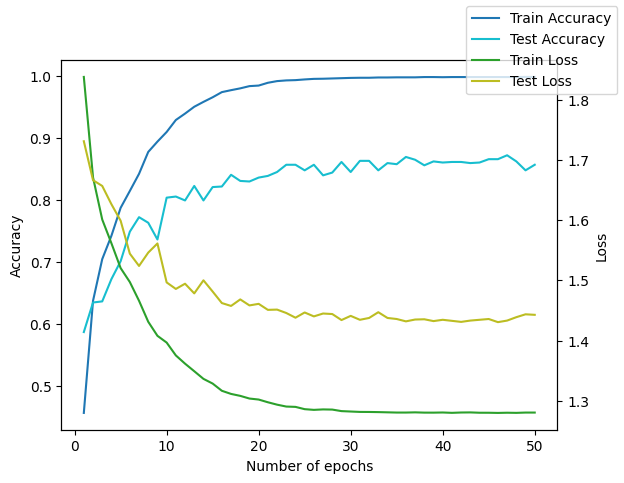

<Figure size 640x480 with 0 Axes>

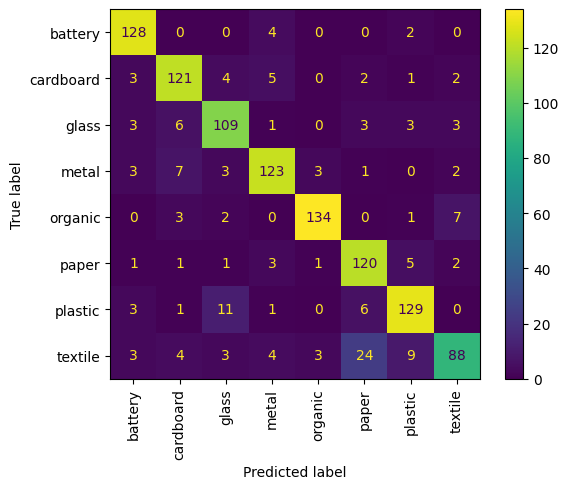

In [20]:
trained_model = train_model(model, full_dataset=False)

########## Save the model ##########
torch.save(trained_model.state_dict(), 'model.pth')


## Submission Kaggle
Cette partie est consacrée à reprendre le modèle entrainé et à prédire une classe sur de nouvelles images non connues et non labellées. Ces prédictions sont exportées dans un fichier .csv avec les identifiants de chaque image afin de pouvoir être évaluées dans le cadre d'une compétiton Kaggle.


In [21]:
class WasteSubmissionDataset(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.image_list = os.listdir(main_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.image_list[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        img_id = os.path.splitext(os.path.basename(img_loc))[0]
        return tensor_image, img_id

test_dataset = WasteSubmissionDataset(main_dir=TEST_DATA, transform=test_transform)
submission_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)



Ici, on redéfinit une classe personnalisée pour transformer nos images en Tensors. Les transformations appliquées sont identiques à celles du set de validation.

In [22]:
def generate_submission(model, submission_loader):
    model.eval()

    images_id = []
    predictions = []
    
    with torch.no_grad():
        for batch_idx, (img, tuple_img_id) in enumerate(submission_loader):
            img = img.to(device)
            output = model(img)
            prob = torch.nn.functional.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)
            for i, img_id  in enumerate(tuple_img_id):
                images_id.append(img_id)
                predictions.append(CLASSES[predicted[i]])
    
    
    df = pd.DataFrame({'ID': images_id, 'Label': predictions})
    df.to_csv('submission.csv', index=False)
    
    print(df.head())

generate_submission(trained_model, submission_loader)

                                     ID    Label
0  69d436c1-429f-4c15-b780-bf599f779ae2  battery
1  02b8a2d3-7444-4e50-9f46-d1fbc7f1c5a4  organic
2  aff9561d-77cc-4d15-a77f-9b3477acb968    paper
3  772a7ee5-97c0-4b4f-82c1-4e36486fb488  battery
4  69e14833-a7be-45e7-8c35-7504245e72ab  textile
